# Analysis of Resulting PoLo Paths

Here, I analyze the paths found by the PoLo method and check how closely they match the MOAs in [DrugMechDB](https://sulab.github.io/DrugMechDB/).

In [1]:
import pandas as pd
import os.path as osp
import os
import statistics
from collections import Counter
from urllib import request
import json
from matplotlib import pyplot as plt
from matplotlib_venn import venn2_unweighted
import numpy as np
from tqdm import tqdm
from collections import defaultdict

## Load in the DrugMechDB file:

In [2]:
VALIDATION_DIR = "../data/validation"
MAPPING_DIR = "../data/mappings"
KG_DIR = "../data/kg"

In [3]:
url = "https://raw.githubusercontent.com/SuLab/DrugMechDB/1.0/indication_paths.json"

In [4]:
with request.urlopen(url) as fl:
    data_json = json.loads(fl.read())
    # json.dump(dict(data_json), filepath)
    # print(data_json)

Are there the same number of paths as before?

In [5]:
len(data_json)

123

Create a new object containing only those which end in a BP node.

Let's also get all the unique BPs involved:

**It is worth noting that there are lots of non-drug compounds in here, such as carbovir triphosphate and prostaglandins, which act as middle players in the paths.**

In [6]:
bp_paths = []
bp_path_lengths = []
bps = set()
for path in data_json:
    for count, node in enumerate(path["nodes"]):
        # if any node is BP,
        if node["label"] == "Biological Process":
            bp_paths.append(path)
            bp_path_lengths.append(count)
            bps.add(path["nodes"][count]["id"])

In [7]:
len(bp_paths)

100

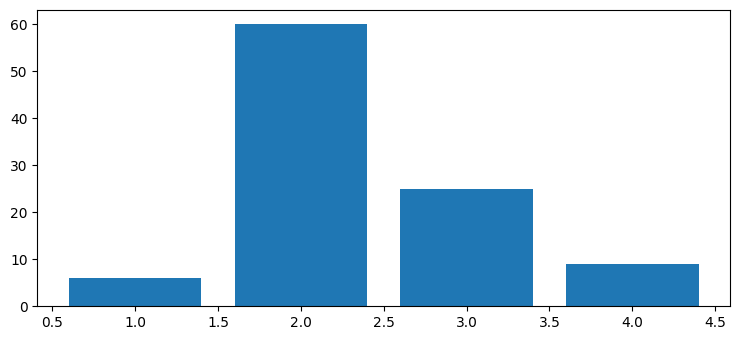

In [8]:
bpath_lens = Counter(bp_path_lengths)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.bar(bpath_lens.keys(), bpath_lens.values())

plt.show()

## Extracting MOAs for Result Validation

Here, we get these MOAs synchronized with the IDs used in our KG, and then we save them in a file for easy comparison against test results.

First, in the `preprocess_drugmechdb` notebook, we've seen that some of the identifiers need to map to others. We'll use the files which were prepared there to do easy mapping here.

In [9]:
# read a json as a dict
with open(osp.join(MAPPING_DIR, "uniprot2ncbi.json")) as fl:
    uniprot2ncbi = json.load(fl)

with open(osp.join(MAPPING_DIR, "drug_id_mapping.json")) as fl:
    drug_id_mapping = json.load(fl)

In [10]:
len(drug_id_mapping)

63

Using these dictionaries, we'll map the nodes to the ontologies used in the KG:

In [11]:
def map_node(node):
    if node["label"] == "Drug" and node["name"] in drug_id_mapping:
        return drug_id_mapping[node["name"]]
    elif node["label"] == "Protein" and node["id"] in uniprot2ncbi:
        return uniprot2ncbi[node["id"]]
    else:
        return node["id"]

Now, get a dictionary of the nodes and relations in each MOA:

In [12]:
validation_moas = defaultdict(lambda: {"nodes": None, "relations": None})
not_mapped = set()
for path in data_json:
    # map the drug name to its pubchem ID
    if path["nodes"][0]["name"] not in drug_id_mapping:
        not_mapped.add(path["nodes"][0]["name"])
        continue
    start_node = drug_id_mapping[path["nodes"][0]["name"]]
    for count, node in enumerate(path["nodes"]):
        # if any node is BP,
        if node["label"] == "Biological Process":
            end_node = path["nodes"][count]["id"]
            # record those MOAs
            validation_moas[(start_node, end_node)]["nodes"] = [
                map_node(i) for i in path["nodes"][0 : len(path["nodes"]) - 1]
            ]
            validation_moas[(start_node, end_node)]["relations"] = [
                i["key"] for i in path["links"][0 : len(path["links"]) - 1]
            ]

len(validation_moas)

53

Does it look how we want it to?

- The keys are tuples comprising a pair of (drug, GO BP)
- The values are dictionaries containing:
    - nodes: a sequence of nodes in the MOA
    - relations: a sequence of relation types in the MOA, which might not necessarily correspond to those in the KG:

## PoLo: Output Paths

Now, we'll get lists from the output file of PoLo:

In [13]:
OUTPUT_DIR = "../data/output"

In [14]:
rel_mapping = {
    "GiG": "interacts",
    "_GiG": "interacts",
    "CuG": "upregulates",
    "_CuG": "upregulates*",
    "CdG": "downregulates",
    "_CdG": "downregulates*",
    "GpBP": "participates",
    "_GpBP": "participates*",
    "CtBP": "induces",
    "_CtBP": "induces*",
}

First, write some functions to do all the desired analyses:

In [15]:
def get_paths(file_path, correct_only=True):
    """Extracts the paths from PoLo's output paths file.
    :param file_path: the path of the output file
    :param correct_only: boolean flag to determine whether or not to extract paths from correct matches only.

    returns a dict of the test pairs as keys and lists of the path patterns traversed as keys
    """
    with open(file_path, "r") as file:
        lines = file.readlines()

    breakpoints = [
        i for i, line in enumerate(lines) if line.startswith("#####################")
    ]

    chunks = []
    startpoint = 0
    for brk in breakpoints:
        chunk = lines[startpoint:brk]
        if not correct_only:
            chunks.append(chunk)
        elif correct_only and chunk[1].strip() == "Reward:1":
            chunks.append(chunk)
        startpoint = brk + 1

    pred_paths = dict()

    for chunk in chunks:
        srt = 0
        current_pair = tuple(chunk[0].split())
        pred_paths[current_pair] = {"nodes": [], "relations": []}
        chunk = chunk[2::]
        breakpoints = [i for i, line in enumerate(chunk) if line.startswith("___")]
        for brk in breakpoints:
            entry = chunk[srt:brk]
            if entry[2].strip() == "1":
                pred_paths[current_pair]["nodes"].append(entry[0].strip().split("\t"))
                pred_paths[current_pair]["relations"].append(
                    entry[1].strip().split("\t")
                )
            srt = brk + 1

    return pred_paths

In [16]:
def get_pattern_breakdown(pred_paths, key=None):
    """Gets a counter of all the path patterns found.

    If key is passed, returns the counter only for that particular test pair.
    """
    if key:
        patterns_traversed = pred_paths[key]["relations"]

    else:
        patterns_traversed = []
        for val in pred_paths.values():
            patterns_traversed.extend(val["relations"])

    patterns_traversed = [
        [rel for rel in i if rel != "NO_OP"] for i in patterns_traversed
    ]
    patterns_traversed = [[rel_mapping[rel] for rel in i] for i in patterns_traversed]
    patterns_traversed = [" -> ".join(i) for i in patterns_traversed]
    return Counter(patterns_traversed)

In [17]:
def plot_pattern_breakdown(pattern_counter, output_path):
    """Makes a histogram of the pattern counts (code written by ChatGPT)"""
    # Separate keys and values
    keys, values = zip(*pattern_counter.items())

    # Create a histogram
    plt.barh(keys, values)

    # Add labels and a title
    plt.xlabel("Correct Predictions")
    plt.ylabel("Metapaths")
    plt.title("Metapath Instances Traversed Between True Pairs")

    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)

    # Save the plot to a file (e.g., 'histogram.png')
    plt.savefig(output_path)

    # Close the plot to free up resources
    plt.close()

The following function simply does the following: checks the %age of proteins that overlap between the DrugMechDB MOA and the paths found between the pairs by PoLo.

TODO:
1. Also analyze the relations and whether they match
2. Whether the proteins are in the correct order
3. If there is a BP in the middle of the MOA, whether that matches too.
4. Get the %age of DrugMechDB pairs predicted correctly / number in the test set (NOTE: this changes per KG size)


In [18]:
def moa_comparison(pred_paths, validation_paths):
    """Compares the MOAS between the results and the DrugMechDB

    :param pred_paths: the dictionary of predicted paths from the first function
    :param validation_paths: the dictionary of validation paths from the DrugMechDB, computed earlier in this notebook.
    """
    found_keys = set(pred_paths.keys()) & validation_paths.keys()
    real_moas = {
        key: val["nodes"] for key, val in validation_paths.items() if key in found_keys
    }
    pred_moas = {
        key: val["nodes"] for key, val in pred_paths.items() if key in found_keys
    }

    matches = dict()
    for key in found_keys:
        true_prots = {i for i in real_moas[key] if i.startswith("ncbigene:")}
        matches[key] = []
        for pred in pred_moas[key]:
            pred_prots = {i for i in pred if i.startswith("ncbigene:")}
            matches[key].append(
                len(true_prots.intersection(pred_prots)) / len(true_prots)
            )

    return matches

In [19]:
def write_json(filepath, data_dict):
    """Writes dict to json"""
    with open(filepath, "w") as json_file:
        json.dump(data_dict, json_file, indent=4)

In [20]:
def process_polo_paths(results_dir, validation_paths, correct_only=True):
    """Wrapper function for all above functions

    Goes through all runs of the experiment and outputs collective results in directory.
    """
    paths_path = osp.join(results_dir, "paths.json")
    patterns_path = osp.join(results_dir, "pattern_counts.json")
    patterns_hist_path = osp.join(results_dir, "pattern_counts.png")
    moa_matches_path = osp.join(results_dir, "moa_matches.json")

    paths = dict()
    patterns = Counter()
    matches = dict()

    # all experimental runs
    runs = os.listdir(results_dir)

    for run in runs:
        if not osp.isdir(osp.join(results_dir, run)):
            continue
        # for each run in an experiment dir, get the paths dir
        fpath = osp.join(results_dir, f"{run}/test_beam/paths_CtBP")

        # get all of the paths per pair
        pred_paths = get_paths(file_path=fpath, correct_only=correct_only)
        for key, val in pred_paths.items():
            if key not in paths:
                paths[key] = val
            else:
                paths[key]["nodes"].extend(pred_paths[key]["nodes"])
                paths[key]["relations"].extend(pred_paths[key]["relations"])

        # get the pattern counts
        patterns_traversed = get_pattern_breakdown(pred_paths)
        patterns = patterns + patterns_traversed

        # get the matches against the DrugMechDB
        moa_matches = moa_comparison(pred_paths, validation_paths)
        for key, val in moa_matches.items():
            if key not in matches:
                matches[key] = val
            else:
                matches[key].extend(val)

    # write everything to files
    paths = {str(key): val for key, val in paths.items()}
    matches = {str(key): val for key, val in matches.items()}

    write_json(paths_path, paths)
    write_json(patterns_path, patterns)
    plot_pattern_breakdown(patterns, patterns_hist_path)
    write_json(moa_matches_path, matches)

In [21]:
kg_sizes = [
    osp.join(osp.join(OUTPUT_DIR, "KG_size_experiment"), i)
    for i in os.listdir(osp.join(OUTPUT_DIR, "KG_size_experiment"))
]

In [22]:
for fol in kg_sizes:
    for subdir in tqdm(os.listdir(fol)):
        output_dir = osp.join(fol, subdir)
        if osp.isdir(output_dir):
            process_polo_paths(output_dir, validation_moas)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


In [23]:
OG_DIR = osp.join(OUTPUT_DIR, "MOA-net-og")

for subdir in tqdm(os.listdir(OG_DIR)):
    output_dir = osp.join(OG_DIR, subdir)
    if osp.isdir(output_dir):
        process_polo_paths(output_dir, validation_moas)

100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


## Performance Metrics

Here, I write code to put all the metrics into a table.

In [24]:
def get_metrics_dict(experiment_dir):
    """Pass the path of a directory for a single experiment (which might contain multiple runs/replicates)

    :param experiment_dir: directory for a single experiment (which might contain multiple runs/replicates)
    :returns: a dictionary of the metric names to
    """
    exp_name = osp.basename(experiment_dir)

    # all experimental runs
    runs = os.listdir(experiment_dir)

    hits_values = {"Hits@1": [], "Hits@3": [], "Hits@10": [], "MRR": []}
    pruned_values = {
        "Hits@1_rule": [],
        "Hits@3_rule": [],
        "Hits@10_rule": [],
        "MRR_rule": [],
    }

    for run in runs:
        if not osp.isdir(osp.join(experiment_dir, run)):
            continue
        # for each run in an experiment dir, get the paths dir
        fpath = osp.join(experiment_dir, f"{run}/scores.txt")

        # Open the file for reading
        with open(fpath, "r") as file:
            # Read the file line by line
            for line in file:
                split_line = line.split(":")
                # Find each metric
                if split_line[0] in set(hits_values.keys()):
                    hits_values[split_line[0]].append(float(split_line[1].strip()))
                elif split_line[0] in set(pruned_values.keys()):
                    pruned_values[split_line[0]].append(float(split_line[1].strip()))

    hits_values = {
        key: (round(sum(val) / len(val), 3), round(statistics.stdev(val), 3))
        for key, val in hits_values.items()
    }
    pruned_values = {
        key.split("_rule")[0]: (
            round(sum(val) / len(val), 3),
            round(statistics.stdev(val), 3),
        )
        for key, val in pruned_values.items()
    }

    scores = {f"{exp_name}": hits_values, f"{exp_name} (pruned)": pruned_values}

    return scores

In [25]:
def process_polo_metrics(results_dir):
    """Gets and formats the metrics from PoLo into a table. Simply pass a directory with multiple experiments in it,
    and this will compute the average and stdev
    """
    final_metrics = dict()

    # all experimental runs
    experiments = os.listdir(results_dir)

    for exp in experiments:
        exp_path = osp.join(results_dir, exp)
        if not osp.isdir(exp_path):
            continue
        # for each experiment dir, get the metrics dict
        metrics_dict = get_metrics_dict(exp_path)
        for key, val in metrics_dict.items():
            final_metrics[key] = val

    metrics_df = pd.DataFrame(final_metrics).transpose().sort_index()

    # Write the rounded DataFrame to a TSV file
    output_file = osp.join(results_dir, "metrics.tsv")
    metrics_df.to_csv(output_file, sep="\t", index=True)

In [26]:
for fol in tqdm(kg_sizes):
    process_polo_metrics(fol)

100%|██████████| 4/4 [00:00<00:00, 279.16it/s]


In [27]:
process_polo_metrics(OG_DIR)

## Confidence Plotting

These next functions are to plot the confidences by the metapaths to understand which metapaths were deemed most important.

In [28]:
def plot_confidences(experiment_dir):
    """Plots the average confidences across runs for an experiment"""
    exp_confs = []
    output_path = osp.join(experiment_dir, "confidences.png")

    # all experimental runs
    runs = os.listdir(experiment_dir)

    for run in runs:
        if not osp.isdir(osp.join(experiment_dir, run)):
            continue
        # for each run in an experiment dir, get the paths dir
        fpath = osp.join(experiment_dir, f"{run}/confidences.txt")

        # Open the file for reading
        with open(fpath, "r") as file:
            confs = json.load(file)["CtBP"]
            confs_dict = dict()
            for mpath in confs:
                if "NO_OP" in mpath:
                    continue
                confs_dict[" -> ".join([rel_mapping[i] for i in mpath[2::]])] = float(
                    mpath[0]
                )
            exp_confs.append(confs_dict)

    avg_confs = dict()
    for key in exp_confs[0].keys():
        avg_confs[key] = statistics.mean(
            [exp_confs[n][key] for n in range(len(exp_confs))]
        )

    avg_confs = dict(sorted(avg_confs.items(), key=lambda item: item[1], reverse=True))

    # Extract keys and values from the dictionary
    keys = list(avg_confs.keys())
    values = list(avg_confs.values())

    plt.figure(figsize=(12, 6))

    # Create a bar plot with keys on the y-axis and values on the x-axis
    plt.barh(keys, values, color="#1d6d8b")

    # Set labels for the axes
    plt.xlabel("Confidence", fontsize=16, labelpad=10, fontweight="bold")
    plt.ylabel("Metapaths", fontsize=16, labelpad=10, fontweight="bold")

    # Set a title for the plot
    plt.title("Confidences per metapath", fontsize=20)

    print(output_path)

    plt.savefig(output_path, dpi=300, bbox_inches="tight")

  0%|          | 0/7 [00:00<?, ?it/s]

../data/output/MOA-net-og/PoLo-2/confidences.png


 14%|█▍        | 1/7 [00:00<00:02,  2.13it/s]

../data/output/MOA-net-og/PoLo-1-alpha_0.1/confidences.png


 43%|████▎     | 3/7 [00:00<00:01,  3.32it/s]

../data/output/MOA-net-og/PoLo/confidences.png


 57%|█████▋    | 4/7 [00:01<00:01,  2.78it/s]

../data/output/MOA-net-og/PoLo-1/confidences.png


 86%|████████▌ | 6/7 [00:01<00:00,  3.38it/s]

../data/output/MOA-net-og/PoLo-2_alpha_0.1/confidences.png


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


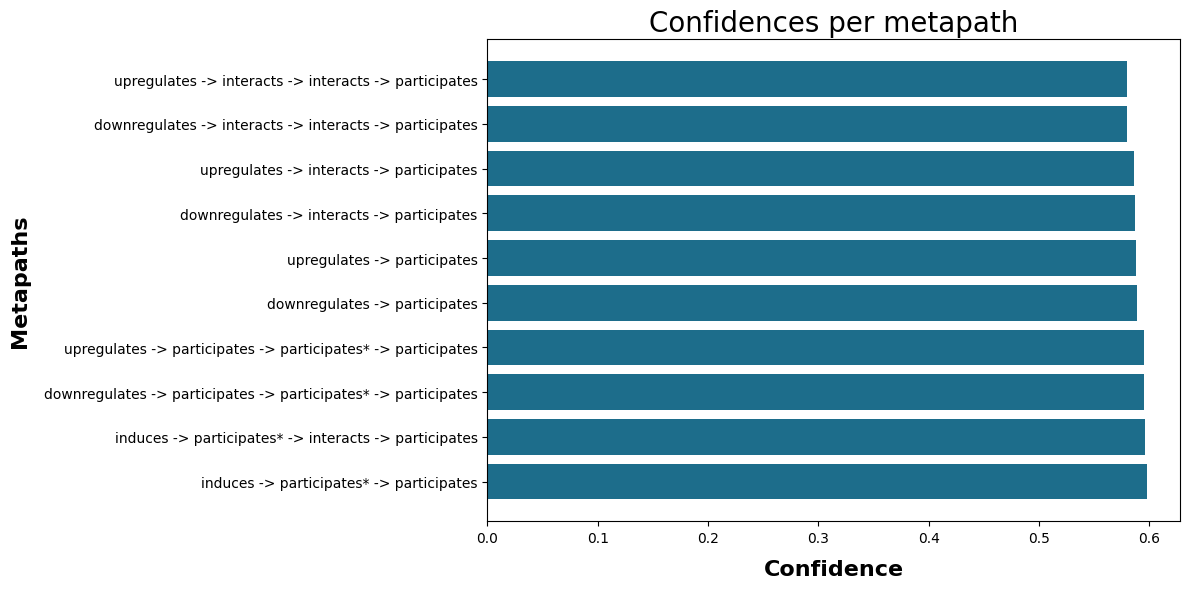

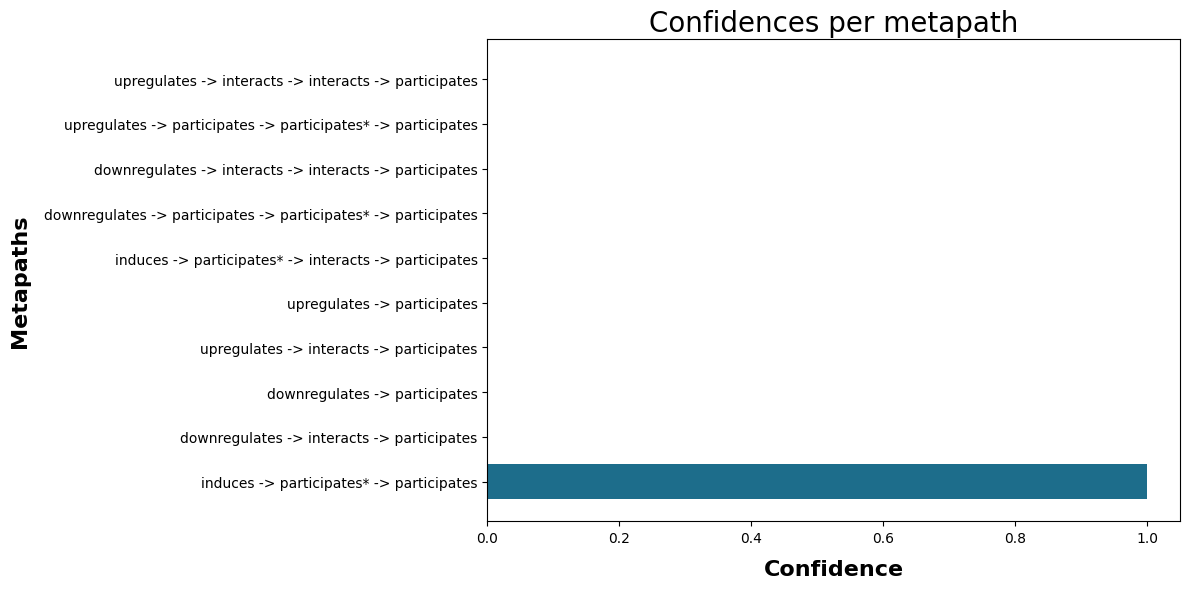

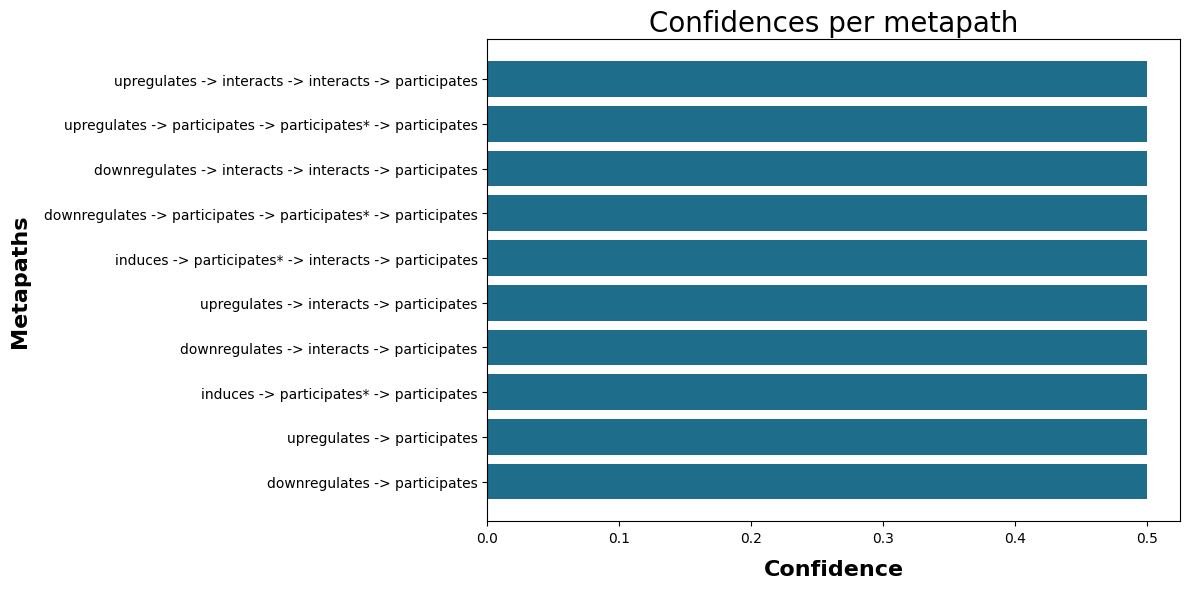

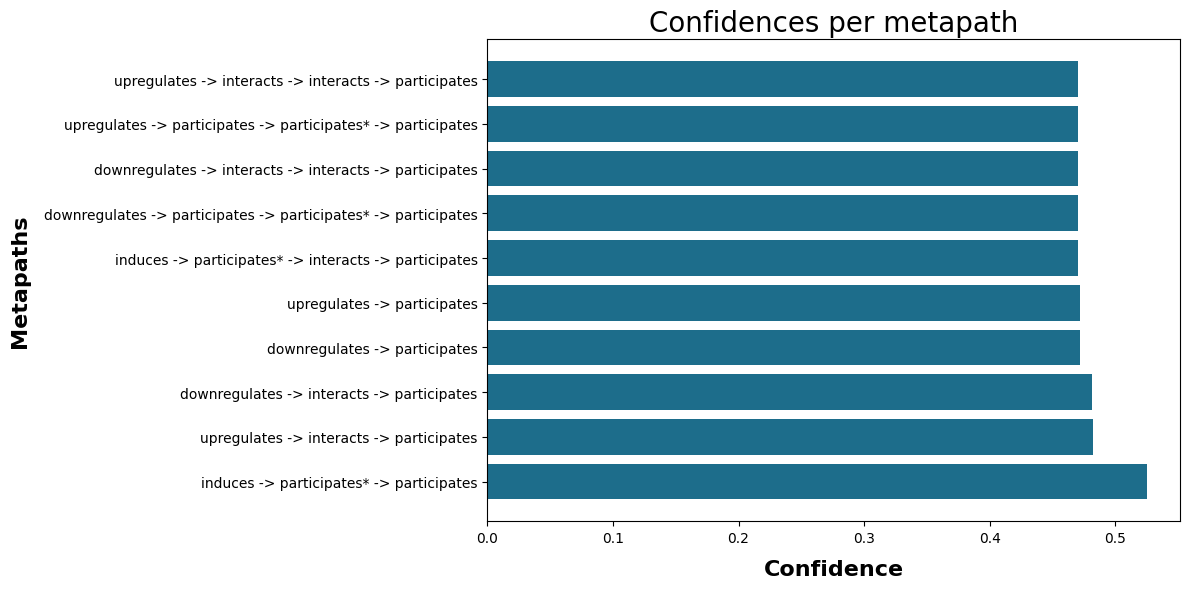

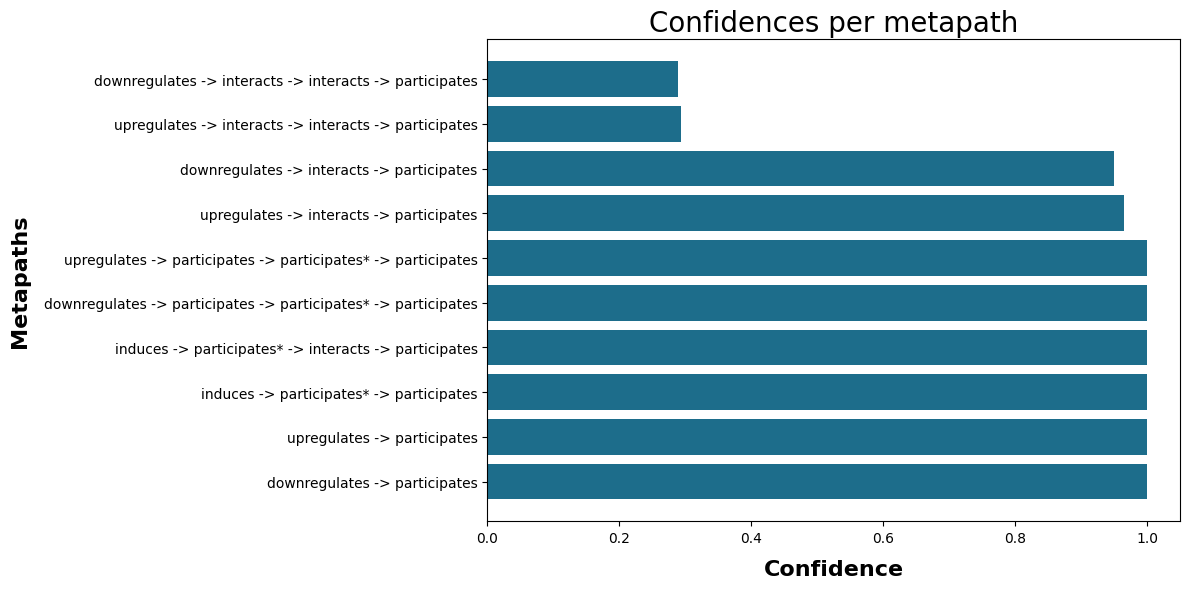

In [29]:
for subdir in tqdm(os.listdir(OG_DIR)):
    output_dir = osp.join(OG_DIR, subdir)
    if osp.isdir(output_dir):
        plot_confidences(output_dir)

## Figure Creation

Figure of first run metrics:

In [30]:
first_run = pd.read_csv(
    osp.join(OUTPUT_DIR, "MOA-net-og/metrics.tsv"), sep="\t", index_col=0
)

In [31]:
first_run.drop(
    ["PoLo-1", "PoLo-1 (pruned)", "PoLo-2", "PoLo-2 (pruned)"], axis=0, inplace=True
)

In [32]:
first_run

,Hits@1,Hits@3,Hits@10,MRR
PoLo,"(0.244, 0.014)","(0.498, 0.011)","(0.767, 0.014)","(0.407, 0.01)"
PoLo (pruned),"(0.068, 0.004)","(0.095, 0.003)","(0.098, 0.003)","(0.081, 0.003)"
PoLo-1-alpha_0.1,"(0.257, 0.008)","(0.508, 0.023)","(0.759, 0.011)","(0.418, 0.011)"
PoLo-1-alpha_0.1 (pruned),"(0.085, 0.023)","(0.132, 0.033)","(0.155, 0.046)","(0.111, 0.03)"
PoLo-2_alpha_0.1,"(0.261, 0.014)","(0.509, 0.024)","(0.765, 0.014)","(0.42, 0.013)"
PoLo-2_alpha_0.1 (pruned),"(0.094, 0.018)","(0.137, 0.029)","(0.156, 0.031)","(0.117, 0.022)"


In [33]:
new_labels = [
    "PoLo",
    "PoLo (pruned)",
    "MARS, naive updates",
    "MARS, naive updates (pruned)",
    "MARS, P2H updates",
    "MARS, P2H updates (pruned)",
]

# change the index labels
first_run.index = new_labels

In [34]:
first_run

,Hits@1,Hits@3,Hits@10,MRR
PoLo,"(0.244, 0.014)","(0.498, 0.011)","(0.767, 0.014)","(0.407, 0.01)"
PoLo (pruned),"(0.068, 0.004)","(0.095, 0.003)","(0.098, 0.003)","(0.081, 0.003)"
"MARS, naive updates","(0.257, 0.008)","(0.508, 0.023)","(0.759, 0.011)","(0.418, 0.011)"
"MARS, naive updates (pruned)","(0.085, 0.023)","(0.132, 0.033)","(0.155, 0.046)","(0.111, 0.03)"
"MARS, P2H updates","(0.261, 0.014)","(0.509, 0.024)","(0.765, 0.014)","(0.42, 0.013)"
"MARS, P2H updates (pruned)","(0.094, 0.018)","(0.137, 0.029)","(0.156, 0.031)","(0.117, 0.022)"


In [35]:
# For every column remove the parentheses, and split by comma getting the first element
table2_values = first_run.applymap(lambda x: x.split(",")[0].replace("(", ""))

table2_sd = first_run.applymap(lambda x: x.split(",")[1].replace(")", ""))

# to numeric
table2_values = table2_values.apply(pd.to_numeric)
table2_sd = table2_sd.apply(pd.to_numeric)

/var/folders/6q/xdd_zynj36q_nl9dhb_0l72w0000gn/T/ipykernel_16989/532760334.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table2_values = first_run.applymap(lambda x: x.split(",")[0].replace("(", ""))
/var/folders/6q/xdd_zynj36q_nl9dhb_0l72w0000gn/T/ipykernel_16989/532760334.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table2_sd = first_run.applymap(lambda x: x.split(",")[1].replace(")", ""))


In [36]:
new_order = [
    "PoLo (pruned)",
    "MARS, P2H updates (pruned)",
    "MARS, naive updates (pruned)",
    "PoLo",
    "MARS, naive updates",
    "MARS, P2H updates",
]
table2_values = table2_values.reindex(index=new_order)
table2_sd = table2_sd.reindex(index=new_order)

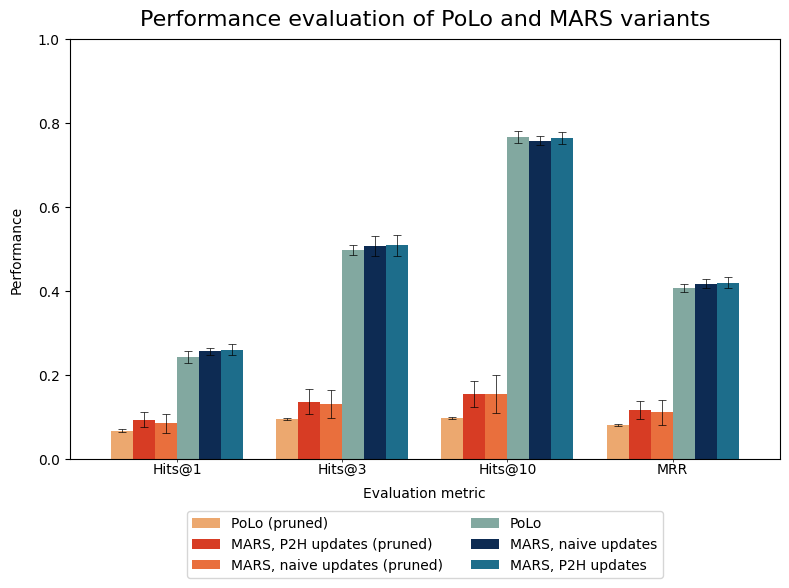

In [37]:
color_dict = {
    "PoLo": "#82a8a0",
    "PoLo (pruned)": "#eca86f",
    "MARS, P2H updates (pruned)": "#d73c24",
    "MARS, naive updates": "#0d2b53",
    "MARS, naive updates (pruned)": "#e96f3d",
    "MARS, P2H updates": "#1d6d8b",
}

table2_values.T.plot.bar(
    color=color_dict,
    yerr=table2_sd.T,
    capsize=4,
    ecolor="black",
    error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
    # make bars thicker
    width=0.8,
)

# Move legend out
plt.legend(loc="center right", borderaxespad=0.0, bbox_to_anchor=(1.6, 0.5))
# Title legend
plt.title(
    "Performance evaluation of PoLo and MARS variants",
    pad=10,
    fontsize=16,
)

# Y label empty
plt.ylabel("Performance", labelpad=10)
# Y label 0-1
plt.ylim(0, 1)

# x labels rotation
plt.xticks(rotation=0)

# make bars thicker and reduce the space between ticks
plt.tick_params(axis="x", width=0.5, length=2, pad=0.5)

# X label
plt.xlabel("Evaluation metric", labelpad=7)

# make the plot wider
plt.gcf().set_size_inches(8, 6)

# legend position down
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2)

plt.savefig(
    osp.join(OUTPUT_DIR, "evaluation_metrics.png"), dpi=400, bbox_inches="tight"
)

plt.show()

Figure of KG size experiment metrics:

In [38]:
KG_SIZES = osp.join(OUTPUT_DIR, "KG_size_experiment")

xsmall = pd.read_csv(osp.join(KG_SIZES, "xsmall_KG/metrics.tsv"), sep="\t", index_col=0)
xsmall["KG"] = [0.5780 for i in range(len(xsmall))]
small = pd.read_csv(osp.join(KG_SIZES, "small_KG/metrics.tsv"), sep="\t", index_col=0)
small["KG"] = [0.5694 for i in range(len(small))]
medium = pd.read_csv(osp.join(KG_SIZES, "medium_KG/metrics.tsv"), sep="\t", index_col=0)
medium["KG"] = [0.7219 for i in range(len(medium))]
full = pd.read_csv(osp.join(KG_SIZES, "full_KG/metrics.tsv"), sep="\t", index_col=0)
full["KG"] = [0.8987 for i in range(len(full))]

table_4 = pd.concat([full, medium, xsmall], axis=0)

In [39]:
table_4 = table_4[["KG", "Hits@1", "Hits@3", "Hits@10", "MRR"]]

In [40]:
# every time 'PoLo-1' occurs in a string, replace it with MARS, naive updates
table_4.index = table_4.index.str.replace("PoLo-1", "MARS, naive updates")
table_4.index = table_4.index.str.replace("PoLo-2", "MARS, P2H updates")

In [41]:
# strip 'Hits@' from each column title
# table_4.columns = [i.strip('Hits@') for i in table_4.columns]

In [42]:
# make a column called 'Model' from the index
table_4["Model"] = table_4.index

In [43]:
table_4

,KG,Hits@1,Hits@3,Hits@10,MRR,Model
PoLo,0.8987,"(0.084, 0.004)","(0.198, 0.013)","(0.341, 0.047)","(0.171, 0.01)",PoLo
PoLo (pruned),0.8987,"(0.159, 0.012)","(0.314, 0.011)","(0.563, 0.014)","(0.273, 0.011)",PoLo (pruned)
"MARS, naive updates",0.8987,"(0.08, 0.017)","(0.186, 0.015)","(0.332, 0.044)","(0.163, 0.021)","MARS, naive updates"
"MARS, naive updates (pruned)",0.8987,"(0.15, 0.01)","(0.278, 0.029)","(0.501, 0.035)","(0.248, 0.013)","MARS, naive updates (pruned)"
"MARS, P2H updates",0.8987,"(0.084, 0.014)","(0.196, 0.013)","(0.35, 0.028)","(0.172, 0.008)","MARS, P2H updates"
"MARS, P2H updates (pruned)",0.8987,"(0.16, 0.013)","(0.312, 0.024)","(0.553, 0.027)","(0.274, 0.014)","MARS, P2H updates (pruned)"
PoLo,0.7219,"(0.14, 0.035)","(0.235, 0.029)","(0.343, 0.027)","(0.205, 0.026)",PoLo
PoLo (pruned),0.7219,"(0.152, 0.03)","(0.265, 0.021)","(0.42, 0.014)","(0.23, 0.02)",PoLo (pruned)
"MARS, naive updates",0.7219,"(0.128, 0.014)","(0.211, 0.016)","(0.321, 0.029)","(0.188, 0.009)","MARS, naive updates"
"MARS, naive updates (pruned)",0.7219,"(0.164, 0.019)","(0.268, 0.015)","(0.398, 0.027)","(0.234, 0.01)","MARS, naive updates (pruned)"


In [44]:
table4_values = table_4[
    [
        "Hits@1",
        "Hits@3",
        "Hits@10",
        "MRR",
    ]
].applymap(lambda x: float(x.split(",")[0].replace("(", "")))

table4_sd = table_4[
    [
        "Hits@1",
        "Hits@3",
        "Hits@10",
        "MRR",
    ]
].applymap(lambda x: float(x.split(",")[1].replace(")", "")))

/var/folders/6q/xdd_zynj36q_nl9dhb_0l72w0000gn/T/ipykernel_16989/3275989492.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table4_values = table_4[
/var/folders/6q/xdd_zynj36q_nl9dhb_0l72w0000gn/T/ipykernel_16989/3275989492.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table4_sd = table_4[


In [45]:
table4_values["KG"] = table_4["KG"]
table4_values["Model"] = table_4["Model"]

In [46]:
# add the string '_error' to each column name in table4_sd
table4_sd.columns = [i + "_error" for i in table4_sd.columns]

In [47]:
# combine all the columns of table4_sd with table4_values
table4_values = pd.concat([table4_values, table4_sd], axis=1)

In [48]:
table4_values

,Hits@1,Hits@3,Hits@10,MRR,KG,Model,Hits@1_error,Hits@3_error,Hits@10_error,MRR_error
PoLo,0.084,0.198,0.341,0.171,0.8987,PoLo,0.004,0.013,0.047,0.010
PoLo (pruned),0.159,0.314,0.563,0.273,0.8987,PoLo (pruned),0.012,0.011,0.014,0.011
"MARS, naive updates",0.080,0.186,0.332,0.163,0.8987,"MARS, naive updates",0.017,0.015,0.044,0.021
"MARS, naive updates (pruned)",0.150,0.278,0.501,0.248,0.8987,"MARS, naive updates (pruned)",0.010,0.029,0.035,0.013
"MARS, P2H updates",0.084,0.196,0.350,0.172,0.8987,"MARS, P2H updates",0.014,0.013,0.028,0.008
"MARS, P2H updates (pruned)",0.160,0.312,0.553,0.274,0.8987,"MARS, P2H updates (pruned)",0.013,0.024,0.027,0.014
PoLo,0.140,0.235,0.343,0.205,0.7219,PoLo,0.035,0.029,0.027,0.026
PoLo (pruned),0.152,0.265,0.420,0.230,0.7219,PoLo (pruned),0.030,0.021,0.014,0.020
"MARS, naive updates",0.128,0.211,0.321,0.188,0.7219,"MARS, naive updates",0.014,0.016,0.029,0.009
"MARS, naive updates (pruned)",0.164,0.268,0.398,0.234,0.7219,"MARS, naive updates (pruned)",0.019,0.015,0.027,0.010


In [49]:
kgs = set(table_4["KG"])
models = set(table_4["Model"])

In [50]:
color_dict = {
    "PoLo": "#82a8a0",
    "PoLo (pruned)": "#eca86f",
    "MARS, P2H updates (pruned)": "#d73c24",
    "MARS, naive updates": "#1d6d8b",
    "MARS, naive updates (pruned)": "#e96f3d",
    "MARS, P2H updates": "#0d2b53",
}

# bar line dict
bar_line_dict = {
    "PoLo": "-.",
    "PoLo (pruned)": "-.",
    "MARS, P2H updates (pruned)": ":",
    "MARS, naive updates": ":",
    "MARS, naive updates (pruned)": "-",
    "MARS, P2H updates": "-",
}

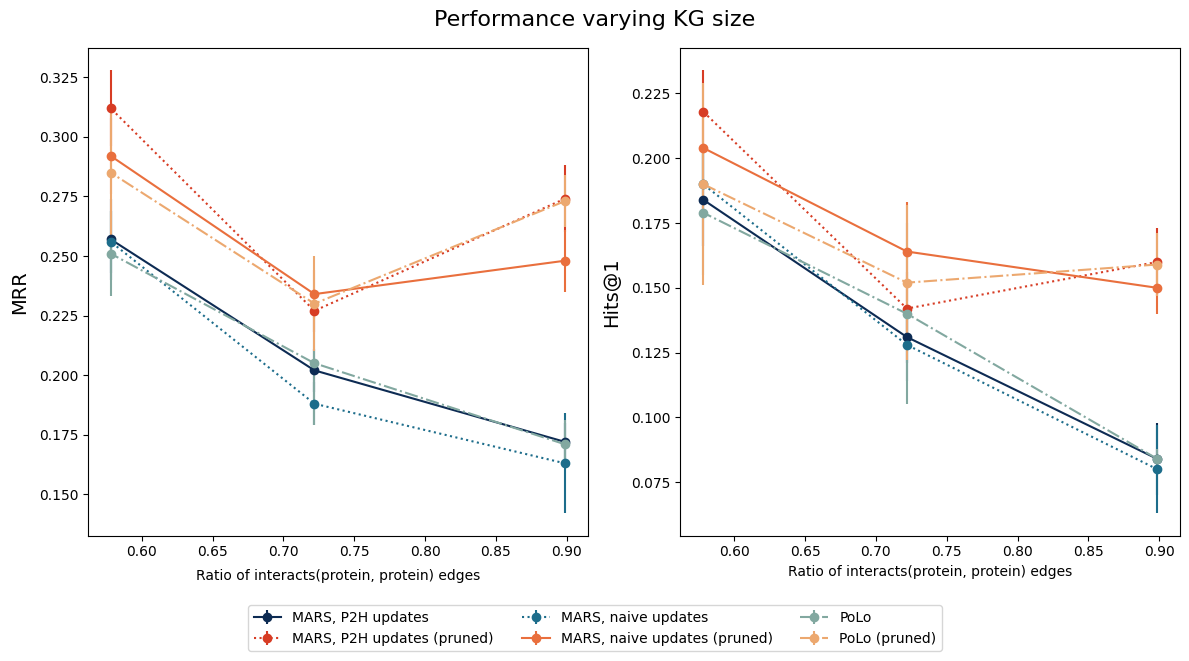

In [51]:
# Group the DataFrame by the 'Model' column
grouped = table4_values.groupby("Model")

# create a figure with two subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# set the title
fig.suptitle("Performance varying KG size", fontsize=16)

for name, group in grouped:
    ax1.errorbar(
        group["KG"],
        group["MRR"],
        yerr=group["MRR_error"],
        marker="o",
        label=name,
        color=color_dict.get(name, "black"),
        linestyle=bar_line_dict.get(name, "-"),
    )

# x label
ax1.set_xlabel("Ratio of interacts(protein, protein) edges", labelpad=7)
ax1.set_ylabel("MRR", labelpad=7, fontsize=14)
plt.grid(False)

# legend position down center of the entire plot
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=3)

# Group the DataFrame by the 'Model' column
grouped = table4_values.groupby("Model")

for name, group in grouped:
    ax2.errorbar(
        group["KG"],
        group["Hits@1"],
        yerr=group["Hits@1_error"],
        marker="o",
        label=name,
        color=color_dict.get(name, "black"),
        linestyle=bar_line_dict.get(name, "-"),
    )

ax2.set_xlabel("Ratio of interacts(protein, protein) edges")
ax2.set_ylabel("Hits@1", labelpad=7, fontsize=14)
plt.grid(False)

plt.savefig(osp.join(OUTPUT_DIR, "metrics_KG_size.png"), dpi=400, bbox_inches="tight")

plt.show()